In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re,string,unicodedata
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [3]:
true['category'] = 1
false['category'] = 0

In [4]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
news = pd.concat([true,false])

<AxesSubplot:xlabel='category', ylabel='count'>

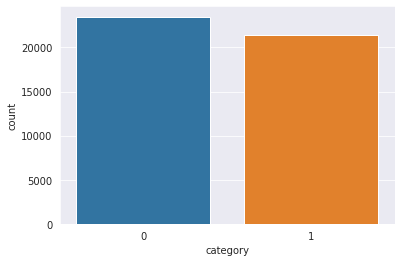

In [7]:
sns.set_style("darkgrid")
# Count occurences of both real and fake news
sns.countplot(x=news.category)

In [8]:
news['text'] = news['text'] + " " + news['title']
del news['title']
del news['subject']
del news['date']

In [9]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [10]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['text']=news['text'].apply(denoise_text)

In [11]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news.text)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(news.text,news.category,random_state = 27)

In [13]:
max_features = 10000
maxlen = 300

In [14]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [15]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [16]:
# Model Hyperparameters
batch_size = 256
epochs = 2
embed_size = 100

In [17]:
model = Sequential([
                    Embedding(max_features, embed_size, input_length=maxlen),
                    Bidirectional(LSTM(150, return_sequences=True, dropout=0.25)),
                    LSTM(100, dropout=0.1),
                    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

2022-02-28 14:12:21.531247: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_test,y_test)
)

2022-02-28 14:12:22.462535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
132/132 [==============================] - 446s 3s/step - loss: 0.3379 - acc: 0.9504 - val_loss: 0.1088 - val_acc: 0.9865
Epoch 2/2
132/132 [==============================] - 439s 3s/step - loss: 0.0549 - acc: 0.9942 - val_loss: 0.0789 - val_acc: 0.9799


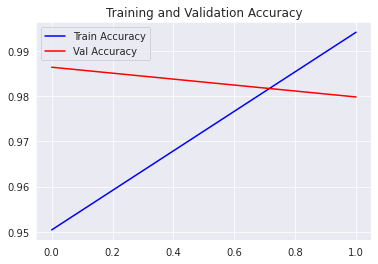

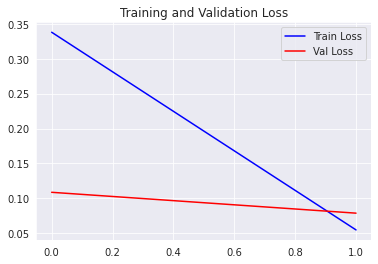

In [19]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(acc, color='b', label='Train Accuracy')
plt.plot(val_acc, color='r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(loss, color='b', label='Train Loss')
plt.plot(val_loss, color='r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()